In [24]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import wandb
import Neural_Lib_Flo as nlb
import training_lib as tl
import torch.nn.functional as F
import data_analysis as da
import torch.nn as nn
import scipy.io
# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_path = '/project/subiculum/new_data/natural_images_awake_postSub.mat'
images_path = '/project/subiculum/new_data/new_images.npy'
from stim_list import stim_list 
responses, _, _,dx_cellType,labels = nlb.load_mat_file(data_path)
dx_cellType=np.ndarray.flatten(dx_cellType)
dx_cellType[dx_cellType==0]=0
ids=scipy.io.loadmat('/project/subiculum/new_data/IDs.mat')
ids=ids['rec']
ids=ids[:,0]
images=np.load(images_path)
train_loader, val_loader, test_loader = nlb.dataloader_with_repeats(responses, images, stim_list,128, ids)
train_loader_best, val_loader_best, test_loader_best = nlb.dataloader_with_repeats(responses[102:103,:,:], images, stim_list,128)
train_loader_high, val_loader_high, test_loader_high = nlb.dataloader_with_repeats(responses[120:121,:,:], images, stim_list,128)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
da.find_duplicate_images(images)

62 8.064516129032258


500

In [34]:
model=nlb.DepthSepConvModel(3,5,11,32,119,gaussian_readout=False,reg_weight=1e-1,image_width=128, image_height=72).to(device)
model_best=nlb.DepthSepConvModel(3,5,11,32,1,gaussian_readout=False,reg_weight=1e-1,image_width=128, image_height=72).to(device)

/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")


In [35]:
tl.training_and_eval_with_lr(model_best,100,train_loader_best, test_loader_best, val_loader_best,device,lr=1e-3,weight_decay=0.1, gamma=1)

Epoch [1/100], validation correlation: 0.1030, trainloss: 0.7758
Epoch [2/100], validation correlation: 0.1375, trainloss: 0.7206
Epoch [3/100], validation correlation: 0.0413, trainloss: 0.7061
Epoch [4/100], validation correlation: 0.1005, trainloss: 0.6956
Epoch [5/100], validation correlation: 0.0425, trainloss: 0.6128
Epoch [6/100], validation correlation: -0.0142, trainloss: 0.4114
Epoch [7/100], validation correlation: -0.0262, trainloss: 0.3558
Early stopping triggered!

Test Loss: 0.3597
Test Correlation: 0.0295


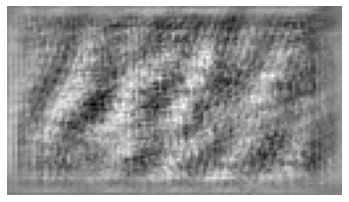

In [22]:
nlb.gradientRF(model_best,'models/best_neuron_model.pt',[0],device ,128,72)

In [38]:
tl.training_and_eval_with_lr(model_best,100,train_loader_high, test_loader_high, val_loader_high,device,lr=1e-5,weight_decay=0.5, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")


Epoch [1/100], validation correlation: 0.0834, trainloss: 0.7524
Epoch [2/100], validation correlation: 0.0855, trainloss: 0.7519
Epoch [3/100], validation correlation: 0.0864, trainloss: 0.7516
Epoch [4/100], validation correlation: 0.0921, trainloss: 0.7522
Epoch [5/100], validation correlation: 0.0914, trainloss: 0.7522
Epoch [6/100], validation correlation: 0.0916, trainloss: 0.7517
Epoch [7/100], validation correlation: 0.0893, trainloss: 0.7519
Epoch [8/100], validation correlation: 0.0948, trainloss: 0.7524
Epoch [9/100], validation correlation: 0.0888, trainloss: 0.7514
Epoch [10/100], validation correlation: 0.0911, trainloss: 0.7520
Epoch [11/100], validation correlation: 0.0931, trainloss: 0.7523
Epoch [12/100], validation correlation: 0.0920, trainloss: 0.7519
Epoch [13/100], validation correlation: 0.0837, trainloss: 0.7519
Early stopping triggered!

Test Loss: 0.7567
Test Correlation: 0.0243


In [7]:
# Define loss function and optimizer
poisson_loss = nlb.PoissonLoss()
gamma = 1e-6
loss_fn = lambda outputs, targets: poisson_loss(outputs, targets) + gamma * model.regularizer()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define the learning rate schedule
lr_scheduler = nlb.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10, verbose=True)

# Define early stopping criteria
early_stopping_patience = 5
early_stopping_counter = 0
best_val_loss = float('-inf')

# Define the number of epochs
epochs = 100


for epoch in range(epochs):
    # Training loop
    loss = nlb.train_epoch_debugging(model, train_loader, optimizer, loss_fn, device)
    
    # Validation loop
    with torch.no_grad():
        val_corrs = nlb.get_correlations(model, val_loader, device)
    validation_correlation = val_corrs.mean()
    
    # Update learning rate schedule
    lr_scheduler.step(validation_correlation)
    
    # Print training and validation losses
    print(f'Epoch [{epoch+1}/{epochs}], validation correlation: {validation_correlation:.4f}, trainloss: {loss:.4f}')
    
    # Check for early stopping
    if validation_correlation > best_val_loss:
        best_val_loss = validation_correlation
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print('Early stopping triggered!')
            break

/usr/local/lib/python3.8/dist-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")



Batch 0
Output range: 0.6821 to 0.7030
Response range: 0.0000 to 133.2000
Output mean: 0.6931, std: 0.0018
Response mean: 6.3291, std: 10.1524


KeyboardInterrupt: 

In [ ]:
# poisson_loss = nlb.PoissonLoss(bias=1e-6)
# gamma = 1e-5  # Reduced regularization strength
# loss_fn = lambda outputs, targets: poisson_loss(outputs, targets) + gamma * model.regularizer()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Define the learning rate schedule
lr_scheduler = nlb.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True)

# Define the number of epochs
epochs = 100

log_epoch, vcorrs, tcorrs, tlosses = [], [], [], []

for epoch in range(epochs):
    # Training loop
    loss = nlb.train_epoch_debugging(model, train_loader, optimizer, loss_fn, device)
    
    if epoch % 5 == 0:  # Evaluate every 5 epochs
        # Validation loop
        with torch.no_grad():
            val_corrs = nlb.get_correlations(model, val_loader, device)
            train_corrs = nlb.get_correlations(model, train_loader, device)
        
        validation_correlation = val_corrs.mean()
        training_correlation = train_corrs.mean()
        
        # Update learning rate schedule
        lr_scheduler.step(validation_correlation)
        
        # Log results
        log_epoch.append(epoch)
        vcorrs.append(validation_correlation)
        tcorrs.append(training_correlation)
        tlosses.append(loss)
        
        # Print training and validation losses
        print(f'Epoch [{epoch+1}/{epochs}], Validation correlation: {validation_correlation:.4f}, '
              f'Training correlation: {training_correlation:.4f}, Train loss: {loss:.4f}')

# Final evaluation
test_corrs = nlb.get_correlations(model, test_loader, device)



In [ ]:
# poisson_loss = nlb.PoissonLoss(bias=1e-6)
# gamma = 1e-5  # Reduced regularization strength
# loss_fn = lambda outputs, targets: poisson_loss(outputs, targets) + gamma * model.regularizer()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Define the learning rate schedule
lr_scheduler = nlb.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True)

# Define the number of epochs
epochs = 100

log_epoch, vcorrs, tcorrs, tlosses = [], [], [], []

for epoch in range(epochs):
    # Training loop
    loss = nlb.train_epoch_debugging(model, train_loader, optimizer, loss_fn, device)
    
    if epoch % 5 == 0:  # Evaluate every 5 epochs
        # Validation loop
        with torch.no_grad():
            val_corrs = nlb.get_correlations(model, val_loader, device)
            train_corrs = nlb.get_correlations(model, train_loader, device)
        
        validation_correlation = val_corrs.mean()
        training_correlation = train_corrs.mean()
        
        # Update learning rate schedule
        lr_scheduler.step(validation_correlation)
        
        # Log results
        log_epoch.append(epoch)
        vcorrs.append(validation_correlation)
        tcorrs.append(training_correlation)
        tlosses.append(loss)
        
        # Print training and validation losses
        print(f'Epoch [{epoch+1}/{epochs}], Validation correlation: {validation_correlation:.4f}, '
              f'Training correlation: {training_correlation:.4f}, Train loss: {loss:.4f}')

# Final evaluation
test_corrs = nlb.get_correlations(model, test_loader, device)

